
# Neural XC training: QiNN and QiCNN models

Note: To showcase the training process we only use 2 epochs. 

The following steps are performed:

1. Load configuration
2. Load dataset
3. Define model
4. Train model

In [3]:
import os
from pathlib import Path

import jax
from jax import config
import jax.numpy as jnp
from jax_dft import np_utils
from jax_dft import scf
from jax_dft import utils
import matplotlib.pyplot as plt
import numpy as np
import scipy

import qedft
from qedft.config.config import Config
from qedft.data_io.dataset_loader import load_molecular_datasets_from_config
from qedft.train.od.train import create_kohn_sham_fn, create_loss_fn, create_training_step

# Set the default dtype as float64
config.update('jax_enable_x64', True)

project_path = os.path.dirname(os.path.dirname(qedft.__file__))
print(f"Project path: {project_path}")

# Initialize a configuration object to manage our settings
# Define the project path, assuming 'settings.yaml' is located in the root directory
project_path = Path(os.path.dirname(os.path.dirname(qedft.__file__)))
# Load configuration settings from a YAML file
config = Config(config_path=project_path / 'qedft' / 'config' / 'train_config.yaml')
config_dict = config.config
print(config_dict)


base_path = project_path / "data" / "od"
base_path = Path(base_path)
list_datasets = load_molecular_datasets_from_config(
    config_dict,
    base_path,
    check_grid_centering=True
)
print(list_datasets)

dataset = list_datasets[0][0]  # first dataset
train_set = list_datasets[0][1] # train set

# Same grids for all datasets
grids = dataset.grids
print(f"Grids: {len(grids)}")
initial_density = scf.get_initial_density(train_set, method='noninteracting')
initial_density  # initial density for training set

# save initial density
# with open('initial_density.pkl', 'wb') as f:
#     pickle.dump(initial_density, f)


2025-04-14 16:32:03.356 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:63 - Loading dataset for h2
2025-04-14 16:32:03.357 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:83 - Loading dataset from /Users/igorsokolov/PycharmProjects/qedft/data/od/h2
2025-04-14 16:32:03.362 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:95 - Training distances: [128, 384]
2025-04-14 16:32:03.363 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:101 - Number of electrons: 2
2025-04-14 16:32:03.363 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:102 - Grid shape: (513,)


Project path: /Users/igorsokolov/PycharmProjects/qedft
{'name': 'test', 'experiment_name': 'test', 'network_type': 'ksr', 'molecule_name': 'h2', 'molecule_names': ['h2'], 'dataset1': [128, 384], 'rng': 0, 'save_plot_loss': False, 'save_every_n': 20, 'activation': 'tanh', 'n_neurons': 513, 'n_layers': 2, 'n_qubits': 9, 'n_reupload_layers': 1, 'use_rzz_parametrized_entanglers': False, 'chebychev_reuploading': False, 'add_reversed_rzz': False, 'entangling_block_type': 'alternate_linear', 'single_qubit_rotations': ['rz', 'rx', 'rz'], 'use_same_parameters': False, 'add_negative_transform': False, 'wrap_with_self_interaction_layer': False, 'wrap_with_global_functional': False, 'use_correlators_in_output': False, 'output_operators': ['Z'], 'use_bias_in_output': False, 'max_train_steps': 10000, 'factr': 1.0, 'pgtol': 1e-14, 'm': 20, 'maxfun': 20, 'maxiter': 2, 'num_iterations': 15, 'ks_iter_to_ignore': 10, 'discount_factor': 0.9, 'alpha': 0.5, 'alpha_decay': 0.9, 'num_mixing_iterations': 1, 'd

Array([[1.36020925e-28, 5.94003127e-28, 1.41151404e-27, ...,
        1.41137527e-27, 5.93883692e-28, 1.35992932e-28],
       [1.93532611e-23, 8.40949500e-23, 1.98255592e-22, ...,
        1.98256097e-22, 8.40953773e-23, 1.93532894e-23]], dtype=float64)

***
## Training (Global) QiQNN

In [4]:
# Settings to make the model work
use_amplitude_encoding = True
if not use_amplitude_encoding:
    config_dict.update({'network_type': 'ksr'})
else:
    config_dict.update({'network_type': 'mlp_ksr'})

config_dict.update({'use_amplitude_encoding': use_amplitude_encoding})
config_dict.update({'jit_loss': False})

In [5]:
from qedft.models.networks import GlobalQiQNN
from qedft.models.wrappers import wrap_network_from_config

model = GlobalQiQNN(config_dict={"n_qubits": 9, "n_features": 2**9, "largest_kernel_width": 2**9, "max_number_conv_layers": 1, "n_var_layers": 1})  # originally 9 in the paper

num_points = 513
prng = jax.random.PRNGKey(0)
inputs = jax.random.uniform(
    prng,
    minval=-4 * jnp.pi,
    maxval=4 * jnp.pi,
    shape=(513,),
)

# Build network
network = model.build_network(inputs)

init_fn, apply_fn = network
_, params = init_fn(prng, input_shape=(-1, num_points, 1))
output = apply_fn(params, inputs)

wrapped_network = wrap_network_from_config(network, grids, config_dict)

# Test direct initialization networks
init_fn, neural_xc_energy_density_fn = wrapped_network
init_params = init_fn(prng, input_shape=(1,))

# JIT the neural_xc_energy_density_fn
neural_xc_energy_density_fn = jax.jit(neural_xc_energy_density_fn)

output = neural_xc_energy_density_fn(inputs, init_params)
print("output.shape", output.shape)

spec, flatten_init_params = np_utils.flatten(init_params)

params = init_fn(prng)
neural_xc_energy_density_fn(inputs, params)

2025-04-14 16:32:07.014 | INFO     | qedft.models.networks:build_network:497 - The number of features is 512, and the statevector is 512 dim.
2025-04-14 16:32:07.015 | INFO     | qedft.models.networks:build_network:501 - The number of features is 512, not 513.
2025-04-14 16:32:07.015 | INFO     | qedft.models.networks:build_network:503 - Forcing to 513 so all data is encoded in the amplitude, provided enough qubits are used, otherwise some data gets lost.
2025-04-14 16:32:07.176 | INFO     | qedft.models.quantum.quantum_models:build_qnn:682 - Building GlobalAmplitudeEncodingQNN QNN with DirectQNN layer_type
2025-04-14 16:32:12.217 | INFO     | qedft.models.wrappers:wrap_network:205 - Global model, ensuring output is scalar (wrap_self_interaction causes global models to output (num_grids,) instead of (1,))


output.shape ()


Array(-0.02090948, dtype=float64)

In [6]:
# Create Kohn-Sham function and its batched version
# kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn(
#     config_dict, dataset, grids, neural_xc_energy_density_fn, spec)

# Non-jit version
from qedft.train.od.train import create_kohn_sham_fn_non_jit
kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn_non_jit(
    config_dict, dataset, grids, neural_xc_energy_density_fn, spec)

# Create and initialize loss function
loss_fn = create_loss_fn(batch_kohn_sham, grids, dataset, config_dict)

# Create value and gradient function
# value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
value_and_grad_fn = jax.value_and_grad(loss_fn)

# Create training step function
training_step = create_training_step(
    value_and_grad_fn, train_set, initial_density,
    save_every_n=1, initial_checkpoint_index=0, checkpoint_dir=project_path / 'tests' / 'qinn' / 'ckpts', spec=spec
)
# Optimize using L-BFGS-B
x, f, info = scipy.optimize.fmin_l_bfgs_b(
    training_step,
    x0=np.array(flatten_init_params),
    maxfun=2,
    factr=config_dict['factr'],
    m=config_dict['m'],
    pgtol=config_dict['pgtol'],
    maxiter=2
)


2025-04-14 16:32:19.267 | INFO     | qedft.train.od.train:_kohn_sham:211 - Using non-JIT kohn_sham_func
2025-04-14 16:33:38.763 | INFO     | qedft.train.od.train:_kohn_sham:211 - Using non-JIT kohn_sham_func
2025-04-14 16:35:21.170 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 0, loss 0.8470595400272447 in 181.9737982749939 sec
2025-04-14 16:35:21.172 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igorsokolov/PycharmProjects/qedft/tests/qinn/ckpts/ckpt-00000
2025-04-14 16:35:21.212 | INFO     | qedft.train.od.train:_kohn_sham:211 - Using non-JIT kohn_sham_func
2025-04-14 16:35:27.150 | INFO     | qedft.train.od.train:_kohn_sham:211 - Using non-JIT kohn_sham_func
2025-04-14 16:35:53.296 | INFO     | qedft.train.od.train:np_value_and_grad_fn:451 - step 1, loss 0.7161671125895553 in 32.086222887039185 sec
2025-04-14 16:35:53.299 | INFO     | qedft.train.od.train:np_value_and_grad_fn:455 - Save checkpoint /Users/igorsokolov/PycharmPr

In [7]:
from qedft.train.od.eval import eval_trained_model

# Plotting the states of the Kohn-Sham calculation for a given distance.
plot_distances = [40, 88, 128, 184, 232,384, 400, 504, 600] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

path_to_ckpt = str(project_path) + '/tests/qinn/ckpts/ckpt-00002'

# Evaluating the trained model for a given distance.
states = eval_trained_model(
    ckpt_path=path_to_ckpt,
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn,
    use_amplitude_encoding=use_amplitude_encoding,
    use_lda=False,
    alpha=config_dict['alpha'],
    alpha_decay=config_dict['alpha_decay'],
    num_mixing_iterations=config_dict['num_mixing_iterations'],
    density_mse_converge_tolerance=config_dict['density_mse_converge_tolerance'],
    enforce_reflection_symmetry=config_dict['enforce_reflection_symmetry'],
)

2025-04-14 16:37:03.317 | INFO     | qedft.train.od.eval:load_model_params:101 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qedft/tests/qinn/ckpts/ckpt-00002
2025-04-14 16:37:03.318 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 40
2025-04-14 16:37:18.758 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 88
2025-04-14 16:37:21.102 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 128
2025-04-14 16:37:22.999 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 184
2025-04-14 16:37:24.591 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 232
2025-04-14 16:37:26.619 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 384
2025-04-14 16:37:32.252 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 400
2025-04-14 16:37:33.926 | INFO     | qedft.train.od.eval:get_states:130 - Processing distance 504
2025-04-14 16:37:36.727 | INFO     | qedft.t

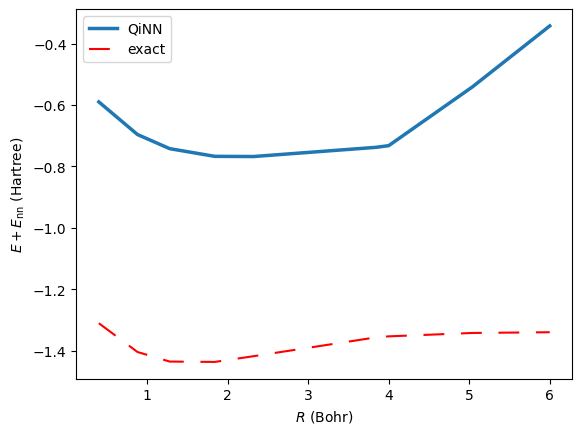

In [8]:
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states.total_energy[:, -1], lw=2.5, label='QiNN')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

***
## Training (Global) QiCNN

In [9]:
from qedft.models.networks import GlobalQiCQNN
from qedft.models.wrappers import wrap_network_from_config

# Important to specify n_features, largest_kernel_width, max_number_conv_layers
# Largest kernel width is the width of the largest kernel in the convolutional layers
# So set it to 2**n_qubits.

# If the number of qubits is too low then NaNs can occur since only a few features are embeded
# causing problems with the optimization.

model = GlobalQiCQNN(config_dict={"n_qubits": 9, "n_features": 2**9, "largest_kernel_width": 2**9, "max_number_conv_layers": 1})

num_points = 513
prng = jax.random.PRNGKey(0)
inputs = jax.random.uniform(
    prng,
    minval=-4 * jnp.pi,
    maxval=4 * jnp.pi,
    shape=(513,),
)

# Build network
network = model.build_network(inputs)

# Initialize parameters and run inference
init_fn, apply_fn = network
_, params = init_fn(prng, input_shape=(-1, num_points, 1))
output = apply_fn(params, inputs)


use_amplitude_encoding = True
if not use_amplitude_encoding:
    config_dict.update({'network_type': 'ksr'})
else:
    config_dict.update({'network_type': 'mlp_ksr'})

wrapped_network = wrap_network_from_config(network, grids, config_dict)

# Test direct initialization networks
init_fn, neural_xc_energy_density_fn = wrapped_network
init_params = init_fn(prng, input_shape=(1,))

# JIT the neural_xc_energy_density_fn
neural_xc_energy_density_fn = jax.jit(neural_xc_energy_density_fn)

output = neural_xc_energy_density_fn(inputs, init_params)
print("output.shape", output.shape)

spec, flatten_init_params = np_utils.flatten(init_params)

params = init_fn(prng)


neural_xc_energy_density_fn(inputs, params)

2025-04-14 16:37:39.192 | INFO     | qedft.models.quantum.convolutional_models:construct_convolutional_model:147 - Using AmplitudeEncodingGlobalQNNLayer layer
2025-04-14 16:37:39.194 | INFO     | qedft.models.quantum.convolutional_models:construct_convolutional_model:177 - GlobalQNNLayer Layer 0: n_qubits_layer 9
2025-04-14 16:37:39.197 | INFO     | qedft.models.quantum.quantum_models:build_qnn:682 - Building GlobalAmplitudeEncodingQNN QNN with DirectQNN layer_type
2025-04-14 16:37:39.277 | INFO     | qedft.models.quantum.convolutional_models:construct_convolutional_model:230 - Adding a single dense layer at the end (outputs last layer 3)


list_kernel_dimensions , list_outputs_per_conv_layer:  [171] [3]


2025-04-14 16:37:44.293 | INFO     | qedft.models.wrappers:wrap_network:205 - Global model, ensuring output is scalar (wrap_self_interaction causes global models to output (num_grids,) instead of (1,))


output.shape ()


Array(-0.0322283, dtype=float64)

In [ ]:
config_dict.update({'use_amplitude_encoding': use_amplitude_encoding})
config_dict.update({'jit_loss': False})

# Create Kohn-Sham function and its batched version
# kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn(
    # config_dict, dataset, grids, neural_xc_energy_density_fn, spec)

# Non-jit version
from qedft.train.od.train import create_kohn_sham_fn_non_jit
kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn_non_jit(
    config_dict, dataset, grids, neural_xc_energy_density_fn, spec)

# Create and initialize loss function
loss_fn = create_loss_fn(batch_kohn_sham, grids, dataset, config_dict)
# Create value and gradient function
# value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

value_and_grad_fn = jax.value_and_grad(loss_fn)

# Create training step function
training_step = create_training_step(
    value_and_grad_fn, train_set, initial_density,
    save_every_n=1, initial_checkpoint_index=0, checkpoint_dir=project_path / 'tests' / 'global_cqnn' / 'ckpts', spec=spec
)
# Optimize using L-BFGS-B
x, f, info = scipy.optimize.fmin_l_bfgs_b(
    training_step,
    x0=np.array(flatten_init_params),
    maxfun=1,
    factr=config_dict['factr'],
    m=config_dict['m'],
    pgtol=config_dict['pgtol'],
    maxiter=1
)


2025-04-14 16:37:55.198 | INFO     | qedft.train.od.train:_kohn_sham:211 - Using non-JIT kohn_sham_func
2025-04-14 16:39:10.440 | INFO     | qedft.train.od.train:_kohn_sham:211 - Using non-JIT kohn_sham_func


In [24]:
from qedft.train.od.eval import eval_trained_model

# Plotting the states of the Kohn-Sham calculation for a given distance.
plot_distances = [40, 88, 128, 184, 232,384, 400, 504, 600] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

path_to_ckpt = str(project_path) + '/tests/global_cqnn/ckpts/ckpt-00001'

# Evaluating the trained model for a given distance.
states = eval_trained_model(
    ckpt_path=path_to_ckpt,
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn,
    use_amplitude_encoding=use_amplitude_encoding,
    use_lda=False,
    alpha=config_dict['alpha'],
    alpha_decay=config_dict['alpha_decay'],
    num_mixing_iterations=config_dict['num_mixing_iterations'],
    density_mse_converge_tolerance=config_dict['density_mse_converge_tolerance'],
    enforce_reflection_symmetry=config_dict['enforce_reflection_symmetry'],
)

2025-04-07 21:34:57.465 | INFO     | qedft.train.od.eval:load_model_params:101 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qedft/tests/global_cqnn/ckpts/ckpt-00004
2025-04-07 21:34:57.482 | INFO     | qedft.train.od.eval:get_states:125 - Processing distance 40
2025-04-07 21:35:00.676 | INFO     | qedft.train.od.eval:get_states:125 - Processing distance 88
2025-04-07 21:35:07.101 | INFO     | qedft.train.od.eval:get_states:125 - Processing distance 128
2025-04-07 21:35:12.723 | INFO     | qedft.train.od.eval:get_states:125 - Processing distance 184
2025-04-07 21:35:16.287 | INFO     | qedft.train.od.eval:get_states:125 - Processing distance 232
2025-04-07 21:35:19.105 | INFO     | qedft.train.od.eval:get_states:125 - Processing distance 384
2025-04-07 21:35:21.844 | INFO     | qedft.train.od.eval:get_states:125 - Processing distance 400
2025-04-07 21:35:24.249 | INFO     | qedft.train.od.eval:get_states:125 - Processing distance 504
2025-04-07 21:35:26.455 | INFO     | 

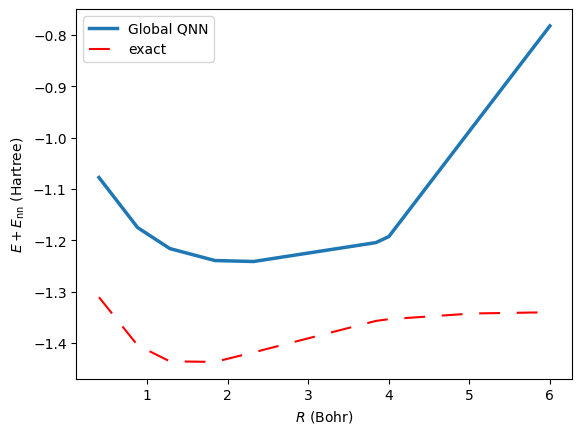

In [25]:
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states.total_energy[:, -1], lw=2.5, label='Global QNN')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

# Summary

This notebook demonstrates training a quantum-enhanced DFT model:

1. Configuration setup with parameters for model architecture, training, etc.
2. Loading molecular dataset for H2 molecule with grid size 513
3. Initializing neural network for exchange-correlation energy density
4. Testing direct initialization networks with random inputs
5. Creating and training Kohn-Sham model:
   - Setting up Kohn-Sham function and batching
   - Initializing loss function
   - Creating training step with gradient computation
   - Optimizing using L-BFGS-B algorithm
6. Training with Local QNN model
7. Training with Global QNN model   
8. Plotting the states of the Kohn-Sham calculation for a given distance.